<h1>Imports and API setups<h1>

In [1]:
from __future__ import print_function    # (at top of module)
import warnings
#warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types

## Read data from CSV

In [2]:
# Read the data from the file
data = pd.read_csv('data_500_entries_youtube.csv')
print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5ygDXis42ncn6kYG14lEVG,Baby Shark,[Pinkfong],77,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,1956582159,Baby Shark Dance | Sing and Dance! | Animal So...
1,spotify:track:7fa9MBXhVfQ8P8Df9OEbD8,Girls Like You (feat. Cardi B),"[Maroon 5, Cardi B]",86,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,1300452389,Maroon 5 - Girls Like You ft. Cardi B
2,spotify:track:6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,[Danny Ocean],83,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,1229501096,Danny Ocean - Me Rehúso (Official Audio)
3,spotify:track:1j6xOGusnyXq3l6IryKF3G,Déjala Que Vuelva (feat. Manuel Turizo),"[Piso 21, Manuel Turizo]",74,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,1216075058,Piso 21 - Déjala Que Vuelva (feat. Manuel Turi...
4,spotify:track:2ijef6ni2amuunRoKTlgww,Sin Pijama,"[Becky G, Natti Natasha]",90,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,1071141995,Becky G Natti Natasha - Sin Pijama (Video Ofic...


## Clean the data

In [3]:
if 'song_id' in data.columns:
    data = data.drop_duplicates(subset=['song_id'], keep='first')
else:
    data = data.drop_duplicates(subset=['song_title'], keep='first')
    
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [4]:
data = data[data.popularity > 50]
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


## Data wrangling

In [11]:
# Check if we have any null items in our data
# data.isnull().sum()

## Setting popularity threshold and adding lables to data

In [6]:
from project_modules import *

final_data = label_data(data, 90)

Number of popular examples after thresholding :  47
Number of not popular examples after thresholding :  523


c:\python27\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [7]:
# Drop unnecessary columns from original data - also some legacy support for a different data format
if 'song_id' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_video_title'], 1, inplace=True)
else:
    final_data.drop(['song_title', 'artist', 'popularity'], 1, inplace=True) 

## Scale the data

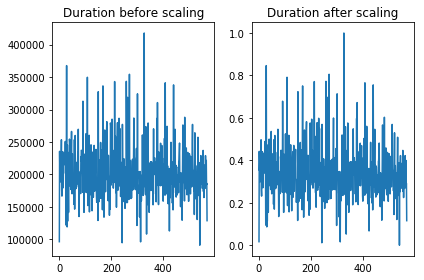

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,is_popular
0,0.838293,0.331118,0.360693,0.399286,0.247690,0.000000,0.75,0.789030,0.636364,0.016514,0.807462,0.522258,1.0,1.000000,0
1,0.502527,0.111965,0.431906,0.049366,0.574298,0.000000,0.75,0.825598,0.000000,0.442256,0.594084,0.444083,1.0,0.664655,0
2,0.797866,0.028251,0.287019,0.083466,0.023312,0.000000,0.75,0.675105,0.090909,0.351029,0.627563,0.420195,1.0,0.628392,0
3,0.779899,0.055152,0.756132,0.104877,0.048692,0.000000,0.75,0.586498,0.090909,0.395074,0.762286,0.868621,1.0,0.621530,0
4,0.731611,0.084961,0.209243,0.041237,0.357908,0.000032,0.75,0.741210,1.000000,0.298565,0.804504,0.847991,0.0,0.547456,0


In [10]:
COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
                    "speechiness", "acousticness", "instrumentalness", 
                    "time_signature", "danceability", "key", 
                    "duration", "loudness", "valence", "mode", "youtube_view_count"]

# Keep data in a temp variable for testing
scaled_data = scale_data_normalize(final_data, COLUMNS_TO_SCALE)

# Plots to see the difference before/after scaling
plt.subplot(1,2,1)
plt.plot(data['duration'])
plt.title("Duration before scaling")

plt.subplot(1,2,2)
plt.plot(scaled_data['duration'])
plt.title("Duration after scaling")
plt.tight_layout()
plt.show()

# Copy data back
final_data = scaled_data.copy()

#Just to check that everything is fine
final_data.head()

## Extract labels from data

In [13]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 570
Number of entries in label data: 570


## Splitting data

In [14]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)
print("Items in training data set : ", str(len(X_train.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in training data set :  285
Items in testing data set:  285


## Model training and prediction

### Logistic Regression

### Train test split

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=3,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy:  0.712280701754

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       268
           1       0.10      0.47      0.16        17

   micro avg       0.71      0.71      0.71       285
   macro avg       0.53      0.60      0.49       285
weighted avg       0.90      0.71      0.79       285

Confusion matrix: 
[[195  73]
 [  9   8]]


c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


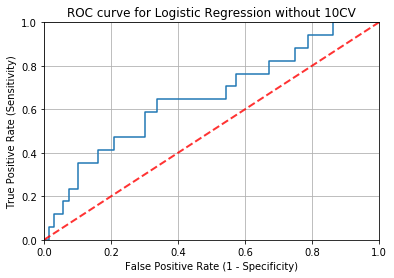

AUC score:  0.654302019315


In [15]:
# Initialize Logistic Regression Model
from sklearn.linear_model import LogisticRegression

# Can use the class_weight argument to assign different weights to the classes
# balanced - calculates the right weights according to the number of examples
# each class

logmodel = LogisticRegression(class_weight='balanced',random_state=3)
#logmodel = LogisticRegression(random_state=3)

print(logmodel)
# Train the model
logmodel.fit(X_train, y_train)

# Classifiy test examples
predictions = logmodel.predict(X_test)
print()

# Print the accuracy score of the model
from sklearn.metrics import accuracy_score
print("Accuracy: ",accuracy_score(y_test, predictions))

print()

# Print the classification report of the model
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: ")
print(confusion_matrix(y_test, predictions))

# ROC curve
from sklearn.metrics import roc_curve
y_pred_prob = logmodel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0,0],[1,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.title('ROC curve for Logistic Regression without 10CV')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
from sklearn.metrics import roc_auc_score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob))

### 10CV

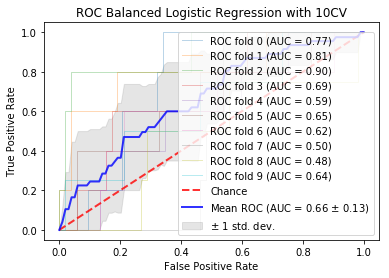

Accuracy mean:  0.651178593034


In [16]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(class_weight='balanced',random_state=3)
X = np.array(X)
y = np.array(y)
tprs = []
aucs = []
accs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    predicts = classifier.predict(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test], predicts))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Balanced Logistic Regression with 10CV')
plt.legend(loc="lower right")
plt.show()

print("Accuracy mean: ",np.mean(accs))

## K Nearest Neighbours

### Train test split

Accuracy:  0.940350877193

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[268   0]
 [ 17   0]]


c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


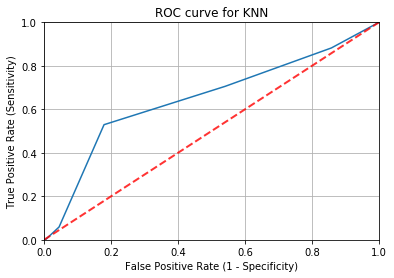

AUC score:  0.649582967515


In [17]:
from sklearn.neighbors import KNeighborsClassifier
nbrs = KNeighborsClassifier(n_neighbors = 14)

nbrs.fit(X_train, y_train)

# Classifiy test examples
predictionsKNN = nbrs.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictionsKNN))
print()
print(classification_report(y_test, predictionsKNN))
print("Confusion matrix: ")
print(confusion_matrix(y_test, predictionsKNN))

# ROC curve
y_pred_prob_knn = nbrs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.title('ROC curve for KNN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_knn))

In [30]:
from sklearn.model_selection import cross_val_score
# Looking for the best k value using the cross validation score
k_range = list(range(1, 25))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='roc_auc')
    k_scores.append(scores.mean())
best_value = max(k_scores)
best_value_index = 0
index = 1
for value in k_scores:
    if value == best_value:
        best_value_index = index
        break
    index = index + 1
    
print(k_scores)
print("Best K: ", best_value_index)

[0.55544629898403486, 0.56311230043541372, 0.58134161828737296, 0.56741382438316401, 0.57748639332365748, 0.58043722786647312, 0.58751814223512344, 0.59697931785195935, 0.60765420899854861, 0.59771498548621194, 0.61936502177068231, 0.60912100870827279, 0.60764423076923091, 0.61666817851959355, 0.6243713715529754, 0.63171534833091436, 0.63917997097242385, 0.62302068214804063, 0.62169992743105951, 0.62618287373004355, 0.61885250362844701, 0.60830279390420894, 0.60587899129172706, 0.59619285195936145]
Best K:  17


Text(0,0.5,'Cross-Validated Accuracy')

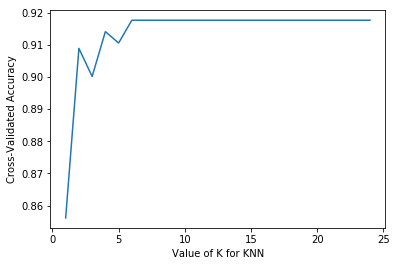

In [19]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

### 10CV

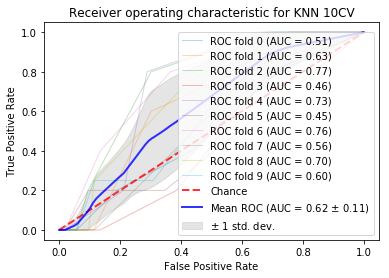

Accuracy mean:  0.917621640308


In [20]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = KNeighborsClassifier(n_neighbors=14)
X = np.array(X)
y = np.array(y)
tprs = []
aucs = []
accs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    preds = classifier.predict(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test], preds))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for KNN 10CV')
plt.legend(loc="lower right")
plt.show()
print("Accuracy mean: ",np.mean(accs))

Below I will use over-sampling with SMOTE(Synthetic Minority Oversampling Technique) to make up for the lack of examples of popular songs. This is one approach to fix the imbalanced class problem.

# Over-sampling with SMOTE

### Imbalanced Logistic Regression

### Train test split

In [21]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
classifier = LogisticRegression(random_state=3)
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier)
smote_model = smote_pipeline.fit(X_train, y_train)
predictionsLogImb = smote_model.predict(X_test)

In [22]:
# This is to showcase the effect of oversampling on our data
# JUST FOR SHOWCASING PURPOSES - OVERSAMPLING IS ONLY DONE ON TRAINING DATA
from collections import Counter
X_smote, y_smote = SMOTE(random_state=4).fit_sample(X, y)
print("Normal data distribution: ", Counter(y))
print("SMOTE data distribution: ", Counter(y_smote))

Normal data distribution:  Counter({0: 523, 1: 47})
SMOTE data distribution:  Counter({0: 523, 1: 523})


Accuracy:  0.722807017544

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.74      0.41      0.83      0.55      0.32       268
          1       0.09      0.41      0.74      0.15      0.55      0.30        17

avg / total       0.90      0.72      0.43      0.79      0.55      0.31       285

Confusion matrix: 
[[199  69]
 [ 10   7]]


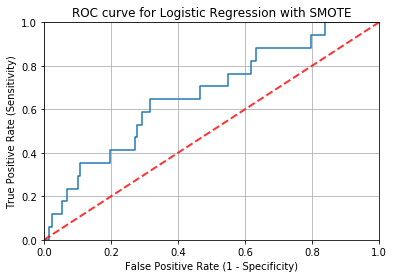

AUC score:  0.669007901668


In [23]:
print("Accuracy: ",accuracy_score(y_test, predictionsLogImb))
print()
print(classification_report_imbalanced(y_test, predictionsLogImb))
print("Confusion matrix: ")
print(confusion_matrix(y_test, predictionsLogImb))

# ROC curve
y_pred_prob_log_imb = smote_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_log_imb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.title('ROC curve for Logistic Regression with SMOTE')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_log_imb))

### 10CV

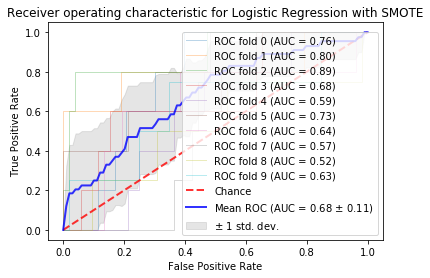

Accuracy mean:  0.665340074324


In [24]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10, random_state=42)
classifier = LogisticRegression(random_state=3)
X = np.array(X)
y = np.array(y)
tprs = []
aucs = []
accs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier)
    model = pipeline.fit(X[train], y[train])
    probas_ = model.predict_proba(X[test])
    preds = model.predict(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test], preds))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Logistic Regression with SMOTE')
plt.legend(loc="lower right")
plt.show()
print("Accuracy mean: ",np.mean(accs))

## Imbalanced KNN

### Train test split

In [25]:
classifierKNN = KNeighborsClassifier(n_neighbors = 14)
smote_pipeline_knn = make_pipeline_imb(SMOTE(), classifierKNN)
smote_model_knn = smote_pipeline_knn.fit(X_train, y_train)
predictionsKnnImb = smote_model_knn.predict(X_test)

Accuracy:  0.491228070175

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.48      0.71      0.64      0.58      0.33       268
          1       0.08      0.71      0.48      0.14      0.58      0.34        17

avg / total       0.91      0.49      0.69      0.61      0.58      0.33       285

Confusion matrix: 
[[128 140]
 [  5  12]]


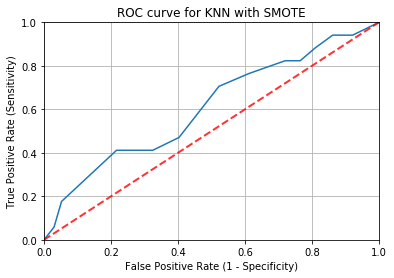

AUC score:  0.607879719052


In [26]:
print("Accuracy: ", accuracy_score(y_test, predictionsKnnImb))
print()
print(classification_report_imbalanced(y_test, predictionsKnnImb))
print("Confusion matrix: ")
print(confusion_matrix(y_test, predictionsKnnImb))

# ROC curve
y_pred_prob_knn_imb = smote_model_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn_imb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.title('ROC curve for KNN with SMOTE')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_knn_imb))

### 10CV

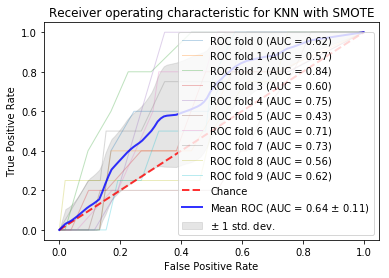

Accuracy mean:  0.56645817129


In [27]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10, random_state=42)
classifier = KNeighborsClassifier(n_neighbors=14)
X = np.array(X)
y = np.array(y)
tprs = []
aucs = []
accs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier)
    model = pipeline.fit(X[train], y[train])
    probas_ = model.predict_proba(X[test])
    preds = model.predict(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test], preds))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for KNN with SMOTE')
plt.legend(loc="lower right")
plt.show()
print("Accuracy mean: ",np.mean(accs))